In [44]:
import sys
sys.path.append('..')

from scripts.autoencoders import InMemoryImageDataset, split_images, ConfigurableAutoencoder
from scripts.measuring_quality import first_order_method, co_ocurrence_matrix, deltah, second_order_method

import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from omegaconf import OmegaConf
import warnings
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

In [45]:
try:
    OmegaConf.register_new_resolver("eval", eval)
except ValueError:
    pass

Elegir el archivo de configuración correspondiente:

In [46]:
config_name = 'config_3' # Elegir

config_path = f'configs/imagenes_reales/{config_name}.yaml'
config = OmegaConf.load(config_path)
config

{'training': {'num_epochs': 200, 'batch_size': 64, 'learning_rate': 0.001, 'scheduler_name': 'elr', 'scheduler_params': {'gamma': 0.97}, 'side_size': 256}, 'model': {'encoding_dim': 1500, 'loss_function': 'mse', 'optimizer': 'adam'}, 'encoder': {'layers': [{'type': 'conv2d', 'filters': 4, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'activation': 'relu'}, {'type': 'conv2d', 'filters': 4, 'kernel_size': 4, 'stride': 2, 'padding': 1, 'activation': 'relu'}, {'type': 'conv2d', 'filters': 8, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': 'relu'}, {'type': 'conv2d', 'filters': 16, 'kernel_size': 4, 'stride': 2, 'padding': 1, 'activation': 'relu'}, {'type': 'conv2d', 'filters': 32, 'kernel_size': 4, 'stride': 2, 'padding': 1, 'activation': 'relu'}, {'type': 'conv2d', 'filters': 64, 'kernel_size': 4, 'stride': 2, 'padding': 1, 'activation': 'relu'}]}, 'decoder': {'layers': [{'type': 'conv2d_transpose', 'filters': 32, 'kernel_size': 4, 'stride': 2, 'padding': 1, 'in_channels': 64, '

Cargo el autoencoder ya entrenado:

In [47]:
image_size = config['training']['side_size']

In [48]:
# 1. Crear una instancia del modelo (debe tener la misma arquitectura)
autoencoder_cargado = ConfigurableAutoencoder(config=config, image_size=image_size)
# 2. Carga los parámetros
autoencoder_cargado.load_state_dict(torch.load(f'data/trained_models/imagenes_reales/{config_name}.pth'))
# 3. Modo evaluación (cuando lo use para inferencia)
autoencoder_cargado.eval()

ConfigurableAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(4, 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU()
    (6): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (11): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(8, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))

Genero dataset de testeo:

In [49]:
def load_tiff_datasets(carpeta):
    carpeta_archivos = f"C:/Users/Bianca/Documents/Archivos/ITBA/Tesis_Maestria/SAR_despeckling_filters_dataset/Main_folder/{carpeta}/"
    archivos_tiff = [f for f in os.listdir(carpeta_archivos) if f.endswith('.tiff')]

    num_imagenes = len(archivos_tiff)
    array_final = np.empty((num_imagenes, 512, 512), dtype=np.uint8)

    for i, archivo in enumerate(archivos_tiff):
        imagen = Image.open(os.path.join(carpeta_archivos, archivo))
        array_imagen = np.array(imagen)[:, :, 0]
        array_final[i] = array_imagen
        
        if (i+1) % 250 == 0:
            print(f'{i+1} de {num_imagenes} imágenes procesadas')

    print(f'\nArray final shape: {array_final.shape}')
    print(f'Máximo valor: {array_final.max()}, mínimo valor: {array_final.min()}')
    
    return array_final

In [50]:
noisy_val = load_tiff_datasets('Noisy_val')


Array final shape: (100, 512, 512)
Máximo valor: 255, mínimo valor: 0


In [51]:
clean_val = load_tiff_datasets('GTruth_val')


Array final shape: (100, 512, 512)
Máximo valor: 255, mínimo valor: 0


In [52]:
clean_val = clean_val[np.array([np.min(img) != np.max(img) for img in clean_val])]
noisy_val = noisy_val[np.array([np.min(img) != np.max(img) for img in noisy_val])]
print(clean_val.shape)
print(noisy_val.shape)

(100, 512, 512)
(100, 512, 512)


In [53]:
autoencoder_cargado.eval() # Para desactivar Dropout, BatchNorm, etc.
batch_size = config['testing']['batch_size']

In [54]:
if config['training']['side_size'] == 512:
    pass

else:
    clean_val = split_images(clean_val, config['training']['side_size'])
    noisy_val = split_images(noisy_val, config['training']['side_size'])    
    
    clean_val = clean_val[np.array([np.min(img) != np.max(img) for img in clean_val])]
    noisy_val = noisy_val[np.array([np.min(img) != np.max(img) for img in noisy_val])]
    
print(clean_val.shape)
print(noisy_val.shape)

(396, 256, 256)
(396, 256, 256)


In [55]:
normalize_to_01 = transforms.Lambda(lambda x: (x - x.min()) / (x.max() - x.min()))

transform = transforms.Compose([
    transforms.ToTensor(),
    normalize_to_01
])

dataset_test = InMemoryImageDataset(noisy_val, clean_val, transform=transform)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

Gráficos de ratios

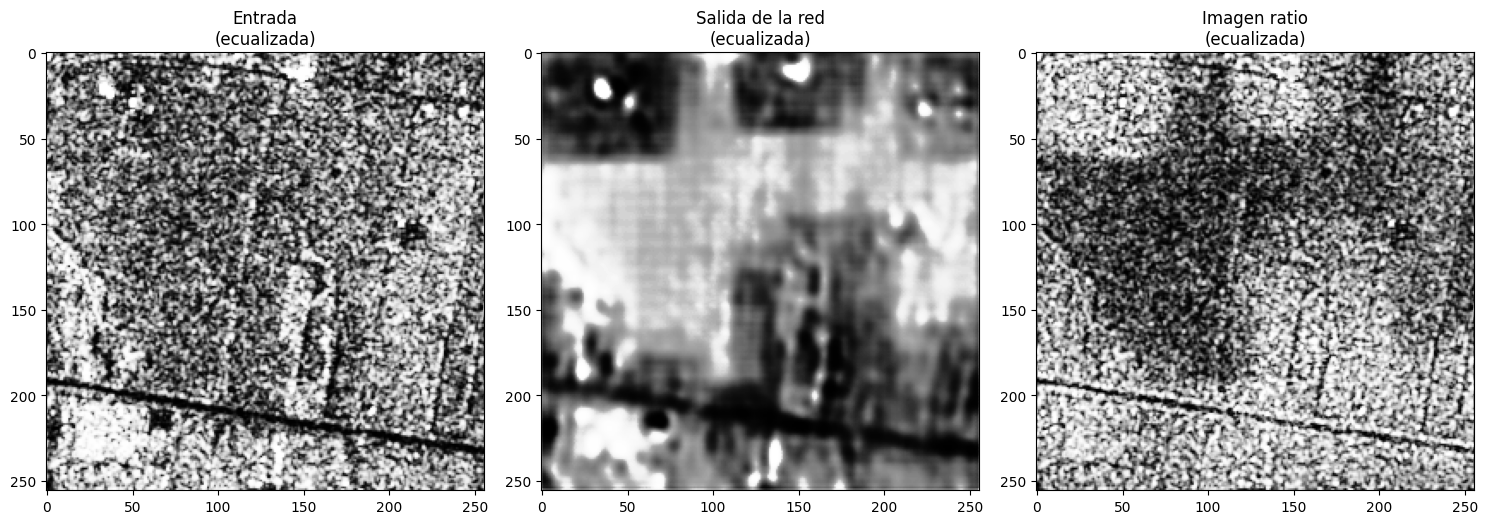

In [58]:
# Aplico el autoencoder a un ejemplo particular del dataset de testeo y veo cómo queda la
# imagen de salida + la imagen ratio.

ecualizar_hist = True  # Si se quiere o no ecualizar el histograma de la imagen

###

def graph_random_image(ecualizar_hist, name_suffix, show_plot=True):

    index = int(noisy_val.shape[0]*np.random.random()) # Índice del ejemplo puntual que se desea seleccionar
    entrada_red, salida_red = dataset_test[index]

    example = entrada_red.float().unsqueeze(0)

    reconstructed = autoencoder_cargado(example) # Aplica el autoencoder al ejemplo

    tamanio = noisy_val.shape[1]

    entrada = entrada_red.view(tamanio, tamanio)
    salida_esperada = salida_red.view(tamanio, tamanio)
    reconstructed = reconstructed.view(tamanio, tamanio)
    ratio = entrada / reconstructed.detach()

    imagenes = [entrada, reconstructed.detach(), ratio]
    titulos = ['Entrada', 'Salida de la red', 'Imagen ratio']

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for ax, imagen, titulo in zip(axes, imagenes, titulos):
        if ecualizar_hist:
            im = imagen.cpu().numpy()
            im = ((im - im.min()) * 255) / (im.max() - im.min())
            imagen = cv2.equalizeHist(im.astype(np.uint8))
            titulo += '\n(ecualizada)'
        
        ax.imshow(imagen, cmap='gray')
        ax.set_title(titulo)

    plt.tight_layout()

    return imagenes, titulos

imagenes, titulos = graph_random_image(ecualizar_hist=ecualizar_hist, name_suffix=1, show_plot=True)